In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

import os
import math

import dask
from dask.distributed import Client
from dask import delayed

import locale 

In [3]:
locale.setlocale(locale.LC_TIME, "es_ES")

'es_ES'

# Funciones

In [ ]:
def FiguraSerieTemporal(sst,Ylabel,Xlabel,TituloFigura,FileOut,Ymin,Ymax):
## Serie temporal anotada con valores maximos y minimos
    dTText = .12
    
    sst_rolling = sst.rolling(time = 360 , center = True).mean()
    
    tmax = sst.isel(sst.argmax(...))
    tmin = sst.isel(sst.argmin(...))
    
    d_tmax = sst.time.isel(sst.argmax(...))
    d_tmin = sst.time.isel(sst.argmin(...))
    
    #Linear fit
    ind = np.isfinite(sst)
    z = np.polyfit(sst.time.astype(np.int64)[ind],sst[ind], 1)
    Dlinearf = z[0] * sst.time.astype(np.int64) + z[1]
    Dslope=z[0]/1.e-9*24*3600*365*100 #paso a C por siglo
    tTendencia =  "\n %2.2f $^\circ$C "%(sst[-1]-sst[0]) + ' desde el ' + sst.time[0].dt.strftime("%d %B %Y").values + " (Tendencia: " + "%2.2f"%(Dslope) + " $^\circ$C/siglo )"

    fig, ax = plt.subplots(1 , 1 , figsize = (14,8))
    ax.plot(sst.time , sst,'c' , label = 'Diario')
    ax.plot(sst_rolling.time , sst_rolling,'b', label='Suavizado (1 año)' , linewidth = '3')
    ax.plot(sst.time,Dlinearf,'b:',linewidth=2,label = 'Tendencia');

    ax.plot(d_tmax , tmax,'rs' , markersize = 12 , markeredgecolor='k')
    ax.plot(d_tmin , tmin,'bs' , markersize = 12 , markeredgecolor='k')

    ax.legend(loc = 4)

    tTActual = sst.time[-1].dt.strftime("%d %B %Y").values + " %2.2f $^\circ$C "%(sst[-1].values)
    tTMaxima =  'Temperatura máxima: ' + "%2.2f ºC"%(tmax) + ' el ' + d_tmax.dt.strftime("%d %B %Y").values
    tTMinima =  'Temperatura mínima: ' + "%2.2f ºC"%(tmin) + ' el ' + d_tmin.dt.strftime("%d %B %Y").values
    tPeriodo =  " [" + sstd.time[0].dt.strftime("%d %B %Y").values + " - "+ sstd.time[-1].dt.strftime("%d %B %Y").values + "]"

    ax.set_title(TituloFigura + tPeriodo + '\n' + tTMaxima + ' - ' + tTMinima + tTendencia);
    ax.text(sst.time[0] , math.floor(ax.get_ylim()[1]*10)/10 , tTActual, va = 'center',
                bbox={'facecolor':'white', 'edgecolor':'none', 'pad':10},size=14)

    ax.grid(linestyle='-', linewidth=.9)
    ax.set_ylabel(Ylabel)
    ax.set_xlabel(Xlabel)
    ax.set_frame_on(False)
    plt.savefig(FileOut)

In [ ]:
def FiguraSerieTemporal_anual(sst,Ylabel,Xlabel,TituloFigura,FileOut,Ymin,Ymax):
# Serie temporal por años    
    dTText = .2
    
    currentYear = datetime.date.today().year
    sstHist = sst.sel(time=slice("1982-01-01", str(currentYear-1)+"-12-31"))

    df         = sstHist.groupby(sstHist.time.dt.dayofyear).mean().to_dataframe(name="mean")
    df["std"]  = sstHist.groupby(sstHist.time.dt.dayofyear).std().values

    for year, yearda in sst.groupby(sst.time.dt.year):
        df[year] = pd.Series(index=yearda["time"].dt.dayofyear, data=yearda.values)
    
    df.index   = pd.date_range(start='01/Jan/2020', end='31/12/2020', freq='D')  

    currentYear = datetime.date.today().year
    indLastData = np.where(df[currentYear].isnull())[0].tolist()[0]-1

    date_form = DateFormatter("1-%b")
    
    #Figura
    fig, ax = plt.subplots(figsize=(14,8))

    ax.fill_between(x=df.index, y1=df["mean"]+2*df["std"], 
                    y2=df["mean"]-2*df["std"],alpha=0.5, color='#D3D3D3',
                    label='1.5*std')

    ax.plot(df.index,df[1982],label='1982')
    
    for year in range(currentYear-4,currentYear,1):
        ax.plot(df.index,df[year],label=year)
    
    ax.plot(df.index,df["mean"],'k',linewidth='3',label='mean')
    
    ax.plot(df.index,df[currentYear],'b',linewidth='3',label=currentYear)
    ax.plot(df.index[indLastData],df[currentYear][indLastData],'bo', markersize=12)

    ax.set_xlim(df.index[0],df.index[365])
    ax.xaxis.set_major_formatter(date_form)

    handles, labels = ax.get_legend_handles_labels()
    order=[6,0,1,2,3,4,5,7]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=4)
    
    ax.grid(linestyle='-', linewidth=.9)

    tPeriodo = ' ['+sst.time[0].dt.strftime("%d %B %Y").values + " - "+ sst.time[-1].dt.strftime("%d %B %Y").values + ']'
    tTActual = sst.time[-1].dt.strftime("%d %B %Y").values + " %2.2f ($^\circ$C) "%(sst[-1].values)
    tTMaxima = 'Temperatura máxima: ' + "%2.2f ºC"%(sst.isel(sst.argmax(...)).values)
    tFechaTMaxima = ' el ' + sst.time.isel(sst.argmax(...)).dt.strftime("%d %B %Y").values

    ax.set_title(TituloFigura + tPeriodo +'\n' + tTActual + '. ' + tTMaxima + tFechaTMaxima);

    ax.set_ylabel(Ylabel)
    ax.set_xlabel(Xlabel)
    ax.set_frame_on(False)
    plt.savefig(FileOut)

In [7]:
Ylabel  = 'Temperatura [($^\circ$C)]'
Xlabel  = 'Fecha'

# Inicio

In [8]:
HOME=os.environ['HOME']   
f = open(HOME+'/.env', 'r')
for line in f.readlines():
    Name=line.strip().split('=')[0]
    Content=line.strip().split('=')[-1]
    if Name=='dirData' or Name=='dirAnalisis':
        exec(Name + "=" + "'" + Content + "'")
f.close()

In [9]:
if os.uname().nodename.lower().find('eemmmbp') != -1:
    imagesDir = dirAnalisis + '/SSTGlobalAnalysis/images'
    dataDir   = dirAnalisis + '/SSTGlobalAnalysis/data'    
elif os.uname().nodename.lower().find('sagams') != -1:
    imagesDir = dirAnalisis + '/SSTGlobalAnalysis/images'
    dataDir   = dirAnalisis + '/SSTGlobalAnalysis/data'
elif os.uname().nodename.lower().find('rossby') != -1:
    imagesDir = dirAnalisis + '/SSTGlobalAnalysis/images'
    dataDir   = dirAnalisis + '/SSTGlobalAnalysis/data'

In [10]:
Titulos = ['Oceano Global','Hemisferio norte','Hemisferio sur','AtlanticoNorte', 'Demarcación marina levantino-balear', 'Demarcación marina noratlántica','Demarcación marina canaria','Demarcación sudatlántica','Demarcación Estrecho y Alborán','Iberian Canary Basin']
Titulos_short = ['GO','NH','SH','NAtl','LEB', 'NOR','CAN','SUD','ESA','IBICan']

## Reading data

In [11]:
it=9

In [12]:
titulo = Titulos[it]
titulo_short = Titulos_short[it]

In [13]:
# Daily data
data = xr.open_dataset(dataDir+'/sstd_mean_'+titulo_short+'.nc')
sstd = data.sst
data = xr.open_dataset(dataDir+'/sstd_anom_mean_'+titulo_short+'.nc')
sstd_anom = data.sst

In [14]:
# Monthly data
data = xr.open_dataset(dataDir+'/sstm_mean_'+titulo_short+'.nc')
sstm = data.sst
data = xr.open_dataset(dataDir+'/sstm_anom_mean_'+titulo_short+'.nc')
sstm_anom = data.sst

## Times series mean Sea Surface Temperature

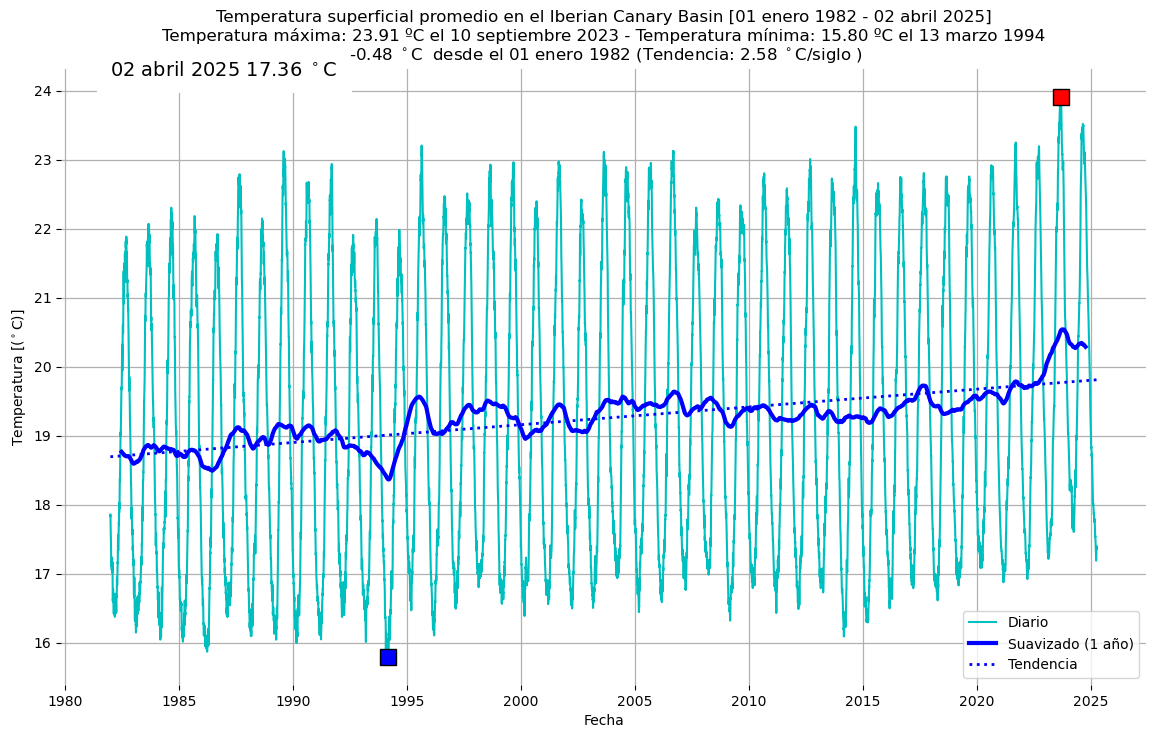

In [15]:
Title1  = 'Temperatura superficial promedio en el '+ titulo
File1 = imagesDir + '/sstd_mean_'+titulo_short+'.png'
FiguraSerieTemporal(sstd,Ylabel,Xlabel,Title1,File1,17.5,19)

## Times series mean Sea Surface Temperature anomaly 

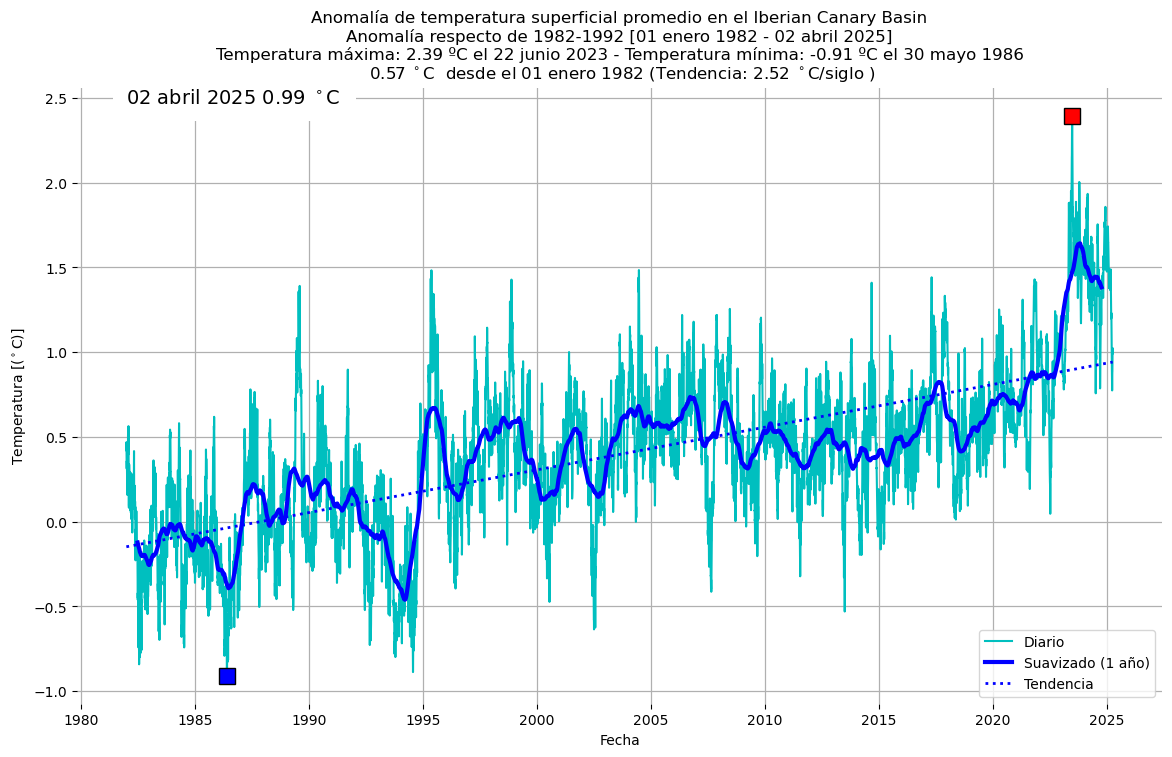

In [18]:
Title2  = 'Anomalía de temperatura superficial promedio en el '+ titulo + '\nAnomalía respecto de 1982-1992'
File2 = imagesDir + '/sstd_anom_mean_'+titulo_short+'.png'
FiguraSerieTemporal(sstd_anom,Ylabel,Xlabel,Title2,File2,-0.25,0.8,)

## Daily times series Sea Surface Temperature

/tmp/ipykernel_686019/2316864589.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(df.index[indLastData],df[currentYear][indLastData],'bo', markersize=12)


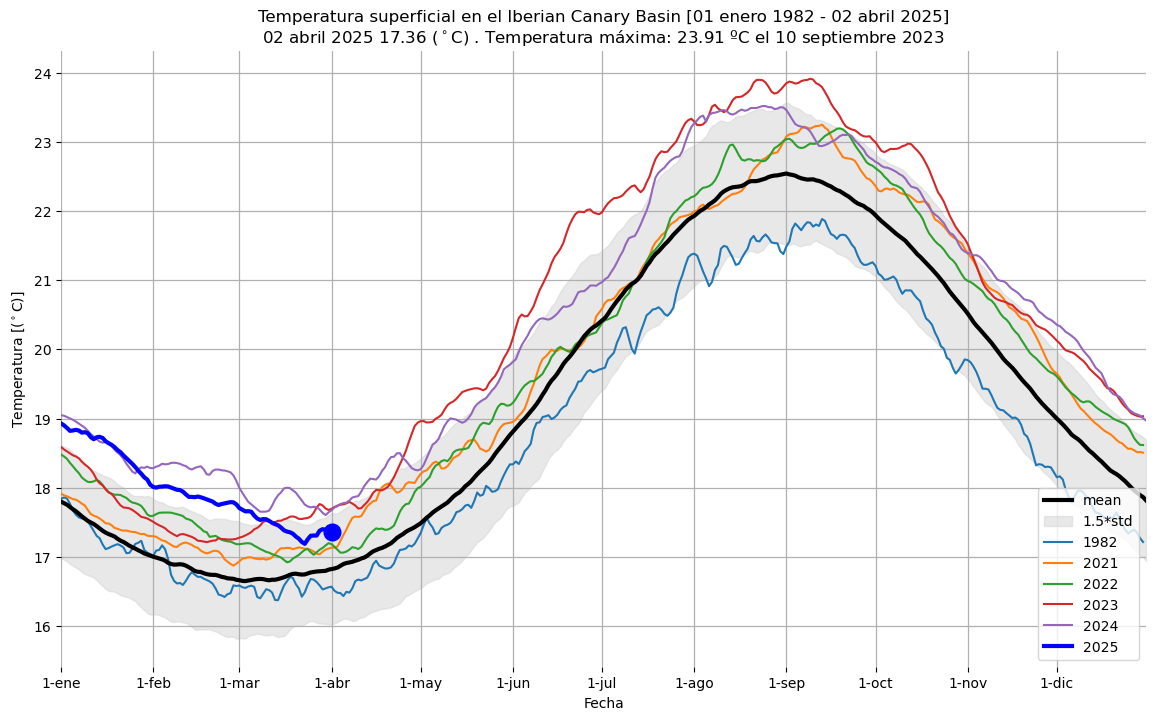

In [19]:
Title3  = 'Temperatura superficial en el '+ titulo
File3 = imagesDir + '/sstd_'+titulo_short+'.png'
FiguraSerieTemporal_anual(sstd,Ylabel,Xlabel,Title3,File3,17.5,19)


## Daily times series anomly Sea Surface Temperature

/tmp/ipykernel_686019/2316864589.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(df.index[indLastData],df[currentYear][indLastData],'bo', markersize=12)


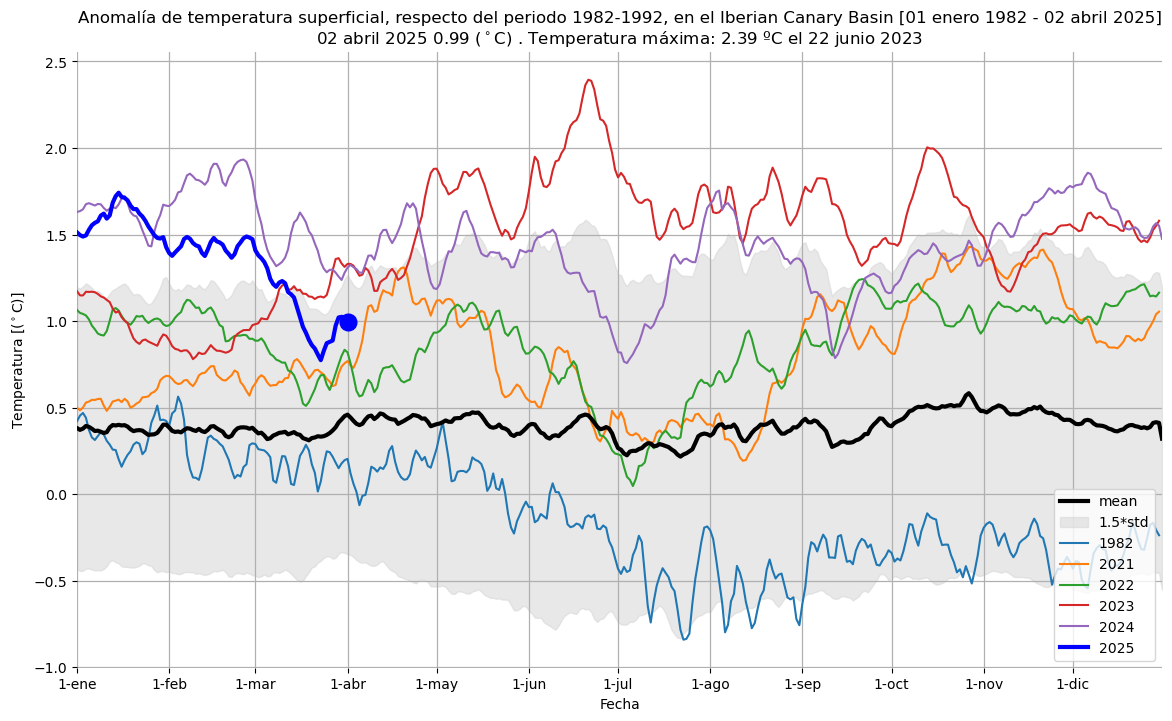

In [20]:
Title4  = 'Anomalía de temperatura superficial, respecto del periodo 1982-1992, en el '+ titulo
File4 = imagesDir + '/sstd_anom_'+titulo_short+'.png'
FiguraSerieTemporal_anual(sstd_anom,Ylabel,Xlabel,Title4,File4,-0.25,0.8)
